In [139]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LeakyReLU, ELU, Activation, PReLU
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [140]:
#Načítanie datasetu
df = pd.read_excel("/content/drive/MyDrive/included_2016_nn_dataset_input.xlsx") #veľký dataset - jeden spekací pás

# Získanie indexov riadkov, zmiešanie indexov, tvorba nového dataframe
indexes = np.arange(len(df))
np.random.shuffle(indexes)
df_shuffled = df.iloc[indexes].reset_index(drop=True)

data_numeric = df_shuffled.apply(pd.to_numeric, errors='coerce').dropna()
X = data_numeric.drop(columns=["Sinter.SP4.Rozsev.Under5mm.%"])
y = data_numeric["Sinter.SP4.Rozsev.Under5mm.%"]

#Normalizácia dát pomocou MinMax
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#Rozdelenie dát
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [141]:

# Definícia CNN modelu
model = Sequential([
    Conv1D(128, kernel_size=3, input_shape=(X_train.shape[1], 1), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dense(1)
])

# SGD optimizer s nižším learning rate
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Plánovanie redukcie learning rate na základe chyby validačných dát
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
callbacks = [reduce_lr]

# Trénovanie modelu s plánovaním learning rate
history = model.fit(X_train, y_train, epochs=300, batch_size=128, validation_data=(X_val, y_val), callbacks=callbacks)

# Vyhodnotenie modelu na testovacích dátach
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)


Epoch 1/300
13/13 [==============================] - 3s 51ms/step - loss: 47.5860 - val_loss: 89.7758 - lr: 0.0100
Epoch 2/300
13/13 [==============================] - 0s 30ms/step - loss: 19.9691 - val_loss: 20.5490 - lr: 0.0100
Epoch 3/300
13/13 [==============================] - 0s 29ms/step - loss: 13.8545 - val_loss: 24.7801 - lr: 0.0100
Epoch 4/300
13/13 [==============================] - 0s 25ms/step - loss: 12.6848 - val_loss: 22.2162 - lr: 0.0100
Epoch 5/300
13/13 [==============================] - 0s 26ms/step - loss: 12.3898 - val_loss: 24.6614 - lr: 0.0100
Epoch 6/300
13/13 [==============================] - 0s 28ms/step - loss: 11.9859 - val_loss: 20.3484 - lr: 0.0100
Epoch 7/300
13/13 [==============================] - 0s 30ms/step - loss: 11.7286 - val_loss: 23.8672 - lr: 0.0100
Epoch 8/300
13/13 [==============================] - 0s 29ms/step - loss: 11.4558 - val_loss: 18.7585 - lr: 0.0100
Epoch 9/300
13/13 [==============================] - 0s 30ms/step - loss: 11.570

In [142]:
# Predikcia na testovacej sade
predicted_values = model.predict(X_test)

# Vypísanie predikovaných a skutočných hodnôt
for i in range(len(predicted_values)):
    print("Predikovaná hodnota:", predicted_values[i][0], "| Skutočná hodnota:", y_test.iloc[i])



19/19 [==============================] - 0s 4ms/step
Predikovaná hodnota: 7.137633 | Skutočná hodnota: 7.40999984741211
Predikovaná hodnota: 6.807543 | Skutočná hodnota: 5.88000011444092
Predikovaná hodnota: 9.067796 | Skutočná hodnota: 9.13000011444092
Predikovaná hodnota: 6.767269 | Skutočná hodnota: 7.05999994277954
Predikovaná hodnota: 7.315894 | Skutočná hodnota: 7.67999982833862
Predikovaná hodnota: 11.587514 | Skutočná hodnota: 11.9300003051758
Predikovaná hodnota: 6.5831437 | Skutočná hodnota: 6.38000011444092
Predikovaná hodnota: 8.018841 | Skutočná hodnota: 8.1899995803833
Predikovaná hodnota: 5.546894 | Skutočná hodnota: 6.71999979019165
Predikovaná hodnota: 5.347843 | Skutočná hodnota: 6.09999990463257
Predikovaná hodnota: 9.232924 | Skutočná hodnota: 10.2700004577637
Predikovaná hodnota: 16.76212 | Skutočná hodnota: 10.8699998855591
Predikovaná hodnota: 8.490321 | Skutočná hodnota: 9.68000030517578
Predikovaná hodnota: 10.358068 | Skutočná hodnota: 9.68000030517578
Prediko

19/19 [==============================] - 0s 18ms/step


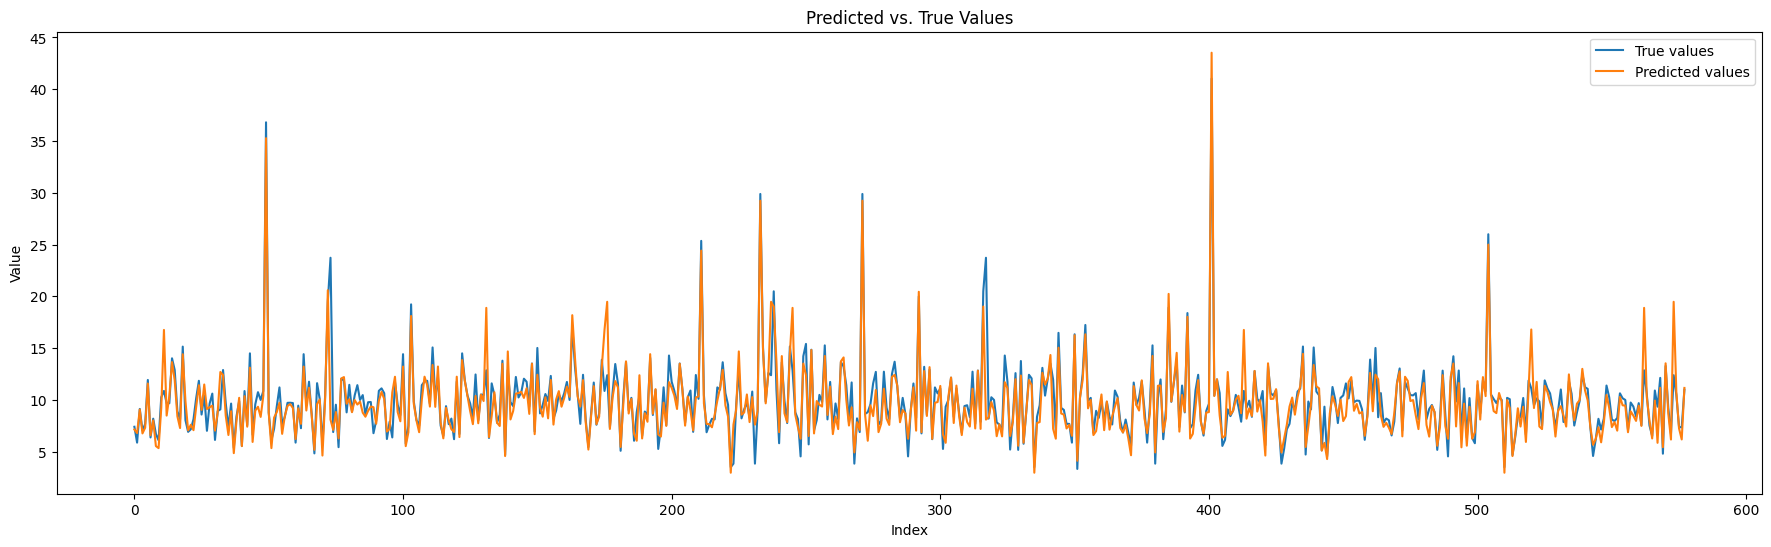

In [143]:

# Predikcia hodnôt pre testovaciu sadu
predicted_values = model.predict(X_test)

# Nastavenie šírky a výšky grafu
plt.figure(figsize=(22, 6))

# Vykreslenie grafu predikovaných a skutočných hodnôt
plt.plot(y_test.values, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values")
plt.legend()
plt.show()

Test Loss: 2.6401619911193848


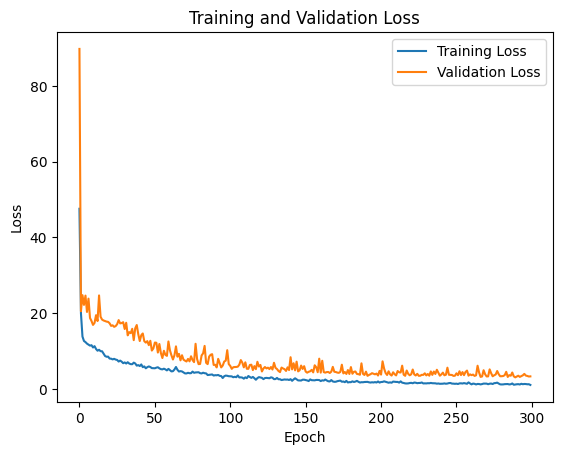

In [144]:
print("Test Loss:", loss)

#Zobrazenie v grafe
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [146]:
# Predikce modelu na testovacích dátach
y_pred = model.predict(X_test)

# Výpočet presnosti
def custom_accuracy(y_test, y_pred):
    bias = np.abs((np.sum(y_test) - np.sum(y_pred)) / len(y_test))
    accuracy = 1 - bias
    return np.abs(accuracy)*100

accuracy = custom_accuracy(y_test.values, y_pred)
print("Accuracy:", accuracy)

# Mean Absolute Error
mae = mean_absolute_error(y_test, predicted_values)
print("Mean Absolute Error:", mae)

# Mean Squared Error
mse = mean_squared_error(y_test, predicted_values)
print("Mean Squared Error:", mse)



19/19 [==============================] - 1s 22ms/step
Accuracy: 73.7920569713553
Mean Absolute Error: 0.9159257354208334
Mean Squared Error: 2.640162145169296
